# Principal component analysis on MNIST

In this notebook, we get an understanding of **principal component analysis (PCA)** using the familiar MNIST data set of handwritten digits.

## 1. Load MNIST data

The next few routines check if the MNIST data is already in the current directory; if not, it is downloaded directly from Yann Le Cun's web site. It is then loaded into memory.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import gzip, sys, os

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [2]:
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data / np.float32(256)

In [3]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')

## 2. Statistics of the data

Principal component analysis chooses projection directions based on the **covariance matrix** of the data. This matrix allows us to contrast the effect of picking coordinate directions (i.e. pixels) versus eigenvector directions. In particular:
* *The ith **diagonal entry** of the covariance is the variance in the ith coordinate (the ith pixel).*
* *The ith **eigenvalue** of the covariance matrix is the variance in the direction of the ith eigenvector.*

In [12]:
# Compute covariance matrix
Sigma = np.cov(train_data, rowvar=0, bias=1)
# Compute coordinate-wise variances, in increasing order
coordinate_variances = np.sort(Sigma.diagonal())
# Compute variances in eigenvector directions, in increasing order
eigenvector_variances = np.sort(np.linalg.eigvalsh(Sigma))

To show the (substantial) benefit of eigenvector projections over coordinate projections, we create a plot that shows the variance lost due to each of these.

For each `k` (projection dimension), we compute:
* How much of the overall variance is lost when we project to the best `k` coordinate directions?
* How much of the overall variance is lost when we project to the top `k` eigenvectors (as in PCA)?

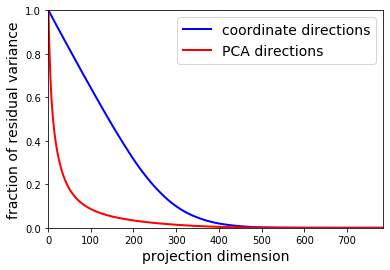

In [13]:
# Compute fraction of overall variance lost when projecting to k coordinate directions
total_coordinate_variance = np.cumsum(coordinate_variances)
total_coordinate_variance = total_coordinate_variance/total_coordinate_variance[783]
# Compute fraction of overall variance lost when projecting to k eigenvector directions
total_eigenvector_variance = np.cumsum(eigenvector_variances)
total_eigenvector_variance = total_eigenvector_variance/total_eigenvector_variance[783]
# Plot these results
plt.plot(np.arange(1,784), total_coordinate_variance[784:0:-1], 'b-', lw=2)
plt.plot(np.arange(1,784), total_eigenvector_variance[784:0:-1], 'r-', lw=2)
plt.xlabel('projection dimension', fontsize=14)
plt.ylabel('fraction of residual variance', fontsize=14)
plt.xlim(0,784)
plt.ylim(0.0,1.0)
plt.legend(['coordinate directions', 'PCA directions'], fontsize=14)
plt.show()

## 3. Projection and reconstruction

We now get a more *visual* feel for what information is lost during dimensionality reduction.

Suppose we find the PCA projection to `k` dimensions. What is the result of:
* Starting with a handwritten digit in the original (784-dimensional) space
* *Projecting* it down to `k` dimensions
* *Reconstructing* an image in 784-dimensional space from this `k`-dimensional projection?

We begin by computing the eigenvalues and eigenvectors of the covariance matrix. The routine `numpy.linalg.eigh` returns these in order of increasing eigenvalue. The eigenvectors are normalized to unit length and returned as columns of a matrix.

In [14]:
eigenvalues, eigenvectors = np.linalg.eigh(Sigma)

Let `U` be the 784-by-`k` matrix whose columns are the top `k` eigenvectors. Then:
* the matrix `transpose(U)` performs the PCA projection onto the top `k` directions
* the matrix `U` reconstructs a point in the original space from its `k` dimensional projection

Thus the product `U*transpose(U)` is a 784-by-784 matrix that does a *projection-followed-by-reconstruction*. The following function returns this matrix for any specified `k`.

In [15]:
# Function that returns the project-and-reconstruct operations as a single matrix
def projection_and_reconstruction(k):
    U = eigenvectors[:,(784-k):784]
    P = np.dot(U,U.T)
    return P

This next routine displays an handwritten digit image given as a 784-dimensional vector. It begins by clipping each entry to lie in the range [0,255]; the images returned after PCA reconstruction might not satisfy this property.

In [16]:
def show_digit(x):
    # Make sure all entries of x are in the range [0,255]
    for i in range(784):
        x[i] = max(0.0, x[i])
        x[i] = min(255.0, x[i])
    # Now display
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

We finally get to our main visualization function. It is invoked as follows:
* **`show_effect_of_PCA(x, k_list)`**

where:
* `x` is the image of a handwritten digit (a 784-dimensional vector)
* `k_list` is a list of projection dimensions (in the range 1 to 784)

It displays the original image as well as the reconstructions after projecting to each of the specified dimensions using PCA.

In [18]:
def show_effect_of_PCA(x, k_list):
    print ("Original:")
    show_digit(x)
    for k in k_list:
        if (k > 0) and (k < 784):
            print ("Projection to dimension ", k)
            P = projection_and_reconstruction(k)
            show_digit(P.dot(x))

Let's try it out on the 1000th data point.

Original:


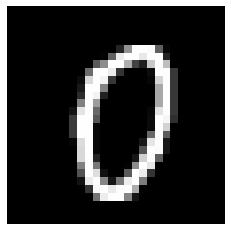

Projection to dimension  100


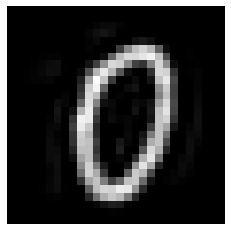

Projection to dimension  50


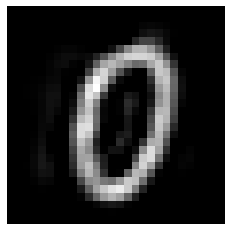

Projection to dimension  25


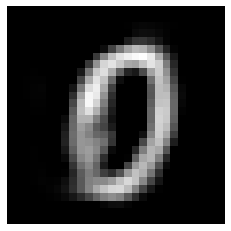

Projection to dimension  10


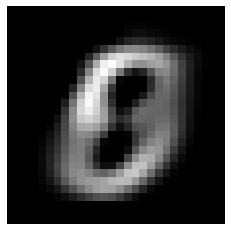

In [19]:
index = 1000
show_effect_of_PCA(train_data[index,], [100, 50, 25, 10])

**<font color="magenta">For you to do: Try plenty of other examples!</font>**